In [91]:
import networkx as nx
import pandas as pd
import numpy as np

import snap as sn
from operator import itemgetter
import community as community


import glob
import os, os.path
import math


import scipy as sp
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering


from scipy.stats import t

from mpl_toolkits.mplot3d import Axes3D


import matplotlib.pyplot as plt
import mplleaflet
from pylab import show
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [92]:
#Get the station data -
##6,j,z rush hour lines are missing
##s station lines are not listed fully
ndata = pd.read_csv("data/nyc_subway_stations_with_lines.csv")

In [93]:
ndata.head(3)

,Unnamed: 0,stop_id,stop_name,stop_lat,stop_lon,Borough,Daytime Routes
0,0,101,Van Cortlandt Park - 242 St,40.889248,-73.898583,Bx,1
1,1,103,238 St,40.884667,-73.900870,Bx,1
2,2,104,231 St,40.878856,-73.904834,Bx,1


In [94]:
#initialize the graph
G.clear()
G = nx.MultiDiGraph(name='NYC Subway Network')

In [95]:
#add nodes and attributes
for i in range(0,len(ndata)):
    G.add_node(ndata.stop_id[i], name = ndata.stop_name[i], line = ndata['Daytime Routes'][i], boro = ndata.Borough[i], lat = ndata.stop_lat[i], lng = ndata.stop_lon[i])

In [96]:
#show the nodes in G
#G.nodes(data=True)

[('G26',
  {'boro': 'Bk',
   'lat': 40.731352000000001,
   'line': 'G',
   'lng': -73.954448999999997,
   'name': 'Greenpoint Av'}),
 ('G24',
  {'boro': 'Q',
   'lat': 40.744064999999999,
   'line': 'G',
   'lng': -73.949724000000003,
   'name': '21 St'}),
 ('G22',
  {'boro': 'Q',
   'lat': 40.746553999999996,
   'line': 'G',
   'lng': -73.943832,
   'name': 'Court Sq'}),
 ('G20',
  {'boro': 'Q',
   'lat': 40.752039000000003,
   'line': 'M R',
   'lng': -73.928781000000001,
   'name': '36 St'}),
 ('G21',
  {'boro': 'Q',
   'lat': 40.748972999999999,
   'line': 'E M R',
   'lng': -73.937243000000009,
   'name': 'Queens Plaza'}),
 ('G28',
  {'boro': 'Bk',
   'lat': 40.724634999999999,
   'line': 'G',
   'lng': -73.951277000000005,
   'name': 'Nassau Av'}),
 ('G29',
  {'boro': 'Bk',
   'lat': 40.712792,
   'line': 'G',
   'lng': -73.951418000000004,
   'name': 'Metropolitan Av'}),
 ('719',
  {'boro': 'Q',
   'lat': 40.747022999999999,
   'line': '7',
   'lng': -73.945263999999995,
   'nam

In [97]:
#get the edge data and attributes
edata = pd.read_csv("data/subway_duration_between_stops_weekday(common_route).csv")

In [98]:
edata.head(2)

,Unnamed: 0,bound,duration,from_stop,from_stop_id,from_stop_sequence,route_id,service_id,to_stop,to_stop_id,to_stop_sequence,train
0,0,N,180,Prospect Park,D26N,1,FS.N01R,B20161106WKD,Botanic Garden,S04N,2,FS
1,1,N,120,Botanic Garden,S04N,2,FS.N01R,B20161106WKD,Park Pl,S03N,3,FS


In [99]:
#add node id to edge data
edata['from_node_id']= edata['from_stop_id'].str[:3]

edata['to_node_id']= edata['to_stop_id'].str[:3]

In [100]:
edata.head(2)

,Unnamed: 0,bound,duration,from_stop,from_stop_id,from_stop_sequence,route_id,service_id,to_stop,to_stop_id,to_stop_sequence,train,from_node_id,to_node_id
0,0,N,180,Prospect Park,D26N,1,FS.N01R,B20161106WKD,Botanic Garden,S04N,2,FS,D26,S04
1,1,N,120,Botanic Garden,S04N,2,FS.N01R,B20161106WKD,Park Pl,S03N,3,FS,S04,S03
2,2,N,120,Park Pl,S03N,3,FS.N01R,B20161106WKD,Franklin Av,S01N,4,FS,S03,S01
3,3,S,120,Franklin Av,S01S,1,FS.S01R,B20161106WKD,Park Pl,S03S,2,FS,S01,S03
4,4,S,90,Park Pl,S03S,2,FS.S01R,B20161106WKD,Botanic Garden,S04S,3,FS,S03,S04


In [101]:
#ADD THE EDGES
for i in range(0,len(edata.from_node_id)):
    G.add_edge(edata.from_node_id[i],edata.to_node_id[i], 
               weight = edata.duration[i],
               edge_id = edata.from_stop_id[i], 
               to_edge_id = edata.to_stop_id[i],
               duration = edata.duration[i],
               from_node_id = edata.from_node_id[i],
               to_node_id = edata.to_node_id[i],
               bound = edata.bound[i],
               train = edata.train[i])


In [102]:
#ADD TRANSFER WITHOUT SWIPE EDGES
tdata = pd.read_csv("data/transfer_without_swipe.csv")
tdata.head(3)

,Unnamed: 0,from_stop_id,to_stop_id,transfer_type,min_transfer_time,from_stop,to_stop,from_line,to_line
0,0,112,A09,2,180,168 St - Washington Hts,168 St,1,A
1,1,112,A09,2,180,168 St - Washington Hts,168 St,1,C
2,2,120,120,2,180,96 St,96 St,1,2


In [103]:
for i in range(0,len(tdata.from_stop_id)):
    G.add_edge(tdata.from_stop_id[i],tdata.to_stop_id[i],
               weight = tdata.min_transfer_time[i],
               edge_id = tdata.from_stop_id[i]+"T_"+tdata.to_line[i], 
               to_edge_id = tdata.to_stop_id[i]+'TF_'+tdata.from_line[i],
               duration = tdata.min_transfer_time[i],
               from_node_id = tdata.from_stop_id[i],
               to_node_id = tdata.to_stop_id[i],
               bound = 'na',
               train = tdata.from_line[i]+" "+ tdata.to_line[i])

In [104]:
print nx.info(G)

Name: NYC Subway Network
Type: MultiDiGraph
Number of nodes: 498
Number of edges: 2594
Average in degree:   5.2088
Average out degree:   5.2088


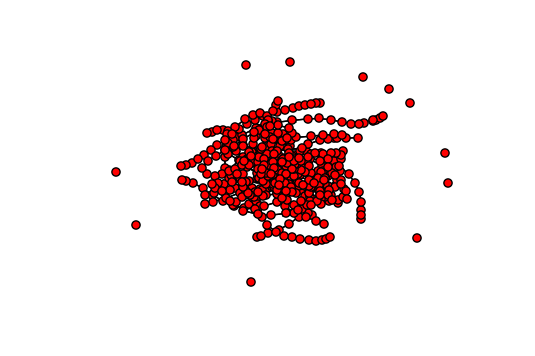

In [105]:
plt.axis("off")
spring_pos = nx.spring_layout(G)
circular =nx.circular_layout(G)
nx.draw_networkx(G, pos = spring_pos, with_labels = False, node_size = 35)

In [117]:
#Method 1 - betweenness_centrality
#compute the betweeness centrality to determine who is the most "important" individual in the network.
#using betweenness centrality is a measure of how many shortest paths pass through a particular vertex.
#Method from http://glowingpython.blogspot.com/2013/02/betweenness-centrality.html


def most_important(G):

  ranking = nx.betweenness_centrality(G).items()
  
  r = [x[1] for x in ranking]
  m = sum(r)/len(r) # mean centrality
  t = m*3 # threshold, we keep only the nodes with 3 times the mean
  Gt = G.copy()
  for k, v in ranking:
    if v < t:
      Gt.remove_node(k)
  return Gt



In [118]:
dominant = most_important(G)

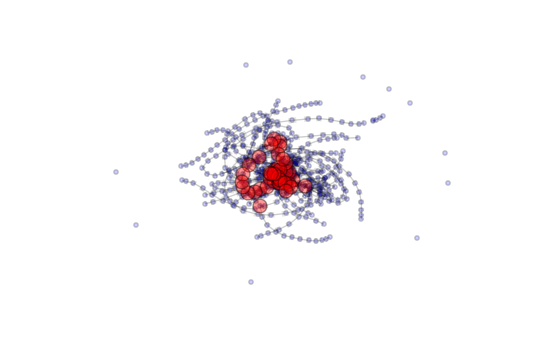

In [119]:
plt.axis("off")

# draw the nodes and the edges (all)
nx.draw_networkx_nodes(G,spring_pos,node_color='b',alpha=0.2,node_size=10)
nx.draw_networkx_edges(G,spring_pos,alpha=0.1)

# draw the most important nodes with a different style
nx.draw_networkx_nodes(dominant,spring_pos,node_color='r',alpha=0.4,node_size=100)
# also the labels this time
#nx.draw_networkx_labels(dominant,spring_pos,font_size=10,font_color='b')
show()

In [120]:
#uses scipi arc pak to determine most important node by spectral theory power method
def most_important(G):

  ranking = nx.eigenvector_centrality_numpy(G).items()
  
  r = [x[1] for x in ranking]
  m = sum(r)/len(r) # mean centrality
  t = m*3 # threshold, we keep only the nodes with 3 times the mean
  Gt = G.copy()
  for k, v in ranking:
    if v < t:
      Gt.remove_node(k)
  return Gt

dominante3 = most_important(G)

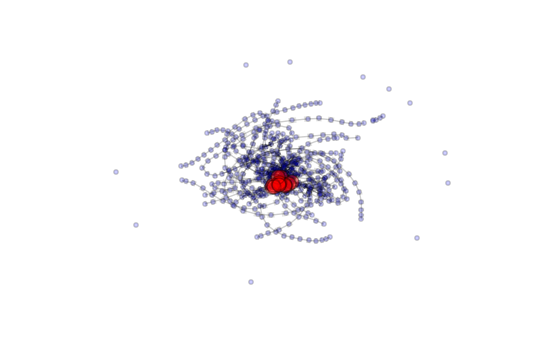

In [121]:
plt.axis("off")

# draw the nodes and the edges (all)
nx.draw_networkx_nodes(G,spring_pos,node_color='b',alpha=0.2,node_size=10)
nx.draw_networkx_edges(G,spring_pos,alpha=0.1)

# draw the most important nodes with a different style
nx.draw_networkx_nodes(dominante3,spring_pos,node_color='r',alpha=0.4,node_size=100)
# also the labels this time
#nx.draw_networkx_labels(dominante3,spring_pos,font_size=10,font_color='b')
show()

In [122]:
#plotting on a map
ndatamap = ndata[['stop_id','stop_lon','stop_lat']]
pos=ndatamap.set_index('stop_id').T.to_dict('list')

fig, ax = plt.subplots()

nx.draw_networkx_nodes(G,pos=pos,node_size=10,node_color='red',edge_color='k',alpha=.5, with_labels=True)
nx.draw_networkx_edges(G,pos=pos,edge_color='gray', alpha=.1)
nx.draw_networkx_labels(G,pos, label_pos =10.3)

mplleaflet.display(fig=ax.figure)


In [123]:
#Dijkstra’s algorithm to find the shortest path in a weighted network
short_paths = path=nx.all_pairs_dijkstra_path(G, weight = 'weight')
sp = pd.DataFrame(short_paths)
sp.to_csv('data/shortest_paths')

In [124]:
#network to file
graph = nx.to_pandas_dataframe(G)
graph.to_csv('data/graph_data')

In [125]:
#node data
node_data = G.nodes(data=True)
nd_data = pd.DataFrame(node_data)
nd_data.to_csv('data/node_data')

In [126]:
#nodes with no edges
no_edges = nx.isolates(G)
noedges = pd.DataFrame(no_edges)
noedges.to_csv('data/no_edges')
print noedges

      0
0   H10
1   H11
2   S12
3   S10
4   H09
5   H08
6   H03
7   H02
8   H01
9   H07
10  H06


In [127]:
[(n,nbrdict) for n,nbrdict in G.adjacency_iter()]

[('G26',
  {'G24': {0: {'bound': 'N',
     'duration': 150,
     'edge_id': 'G26N',
     'from_node_id': 'G26',
     'to_edge_id': 'G24N',
     'to_node_id': 'G24',
     'train': 'G',
     'weight': 150}},
   'G28': {0: {'bound': 'S',
     'duration': 90,
     'edge_id': 'G26S',
     'from_node_id': 'G26',
     'to_edge_id': 'G28S',
     'to_node_id': 'G28',
     'train': 'G',
     'weight': 90}}}),
 ('G24',
  {'G22': {0: {'bound': 'N',
     'duration': 60,
     'edge_id': 'G24N',
     'from_node_id': 'G24',
     'to_edge_id': 'G22N',
     'to_node_id': 'G22',
     'train': 'G',
     'weight': 60}},
   'G26': {0: {'bound': 'S',
     'duration': 180,
     'edge_id': 'G24S',
     'from_node_id': 'G24',
     'to_edge_id': 'G26S',
     'to_node_id': 'G26',
     'train': 'G',
     'weight': 180}}}),
 ('G22',
  {'719': {0: {'bound': 'na',
     'duration': 180,
     'edge_id': 'G22T_7',
     'from_node_id': 'G22',
     'to_edge_id': '719TF_G',
     'to_node_id': '719',
     'train': 'G 7',
  